### K-nearest neighbors

Looking at some [abalone data](http://archive.ics.uci.edu/ml/datasets/Abalone) as [described by Jason Brownlee](https://machinelearningmastery.com/standard-machine-learning-datasets/) :

    "It is a multi-class classification problem, but can also be 
    framed as a regression. The number of observations for each 
    class is not balanced. There are 4,177 observations with 
    8 input variables and 1 output variable. 
    The variable names are as follows:

      column  what
      ------  ----
      0       sex (M, F, I) means Male, Female, or Infant
      1       length                     
      2       diameter
      3       height
      4       whole weight
      5       shucked weight
      6       viscera weight
      7       shell weight
      8       rings                           target

    The baseline performance of predicting the 
    most prevalent class is a classification accuracy 
    of approximately 16%. The baseline performance of predicting the 
    mean value is an RMSE of approximately 3.2 rings."

Examples of work with this data set include 

* [rpubs.com/eawoolard/504789](https://rpubs.com/eawoolard/504789)
* [kaggle.com/hurshd0/eda-of-abalone-features](https://www.kaggle.com/hurshd0/eda-of-abalone-features) (exploratory data analysis)

Jim Mahoney | cs.marlboro.college | March 2 2020

In [20]:
from utilities import *                # my read_abalone(), normalize_column()
from scratch.linear_algebra import *   # scratch's get_column(), distance
from copy import deepcopy
from random import shuffle
from matplotlib import pyplot as plt

raw_abalone = read_abalone()       # original data

In [2]:
def peek(data, nrows=5):
    """ Look at the first few rows """
    for row in data[:nrows]:
        print(row[0], '   ', ' '.join([f'{value:7.3f}' for value in row[1:-1]]), f'  {row[-1]:6.0f} ')

peek(raw_abalone)

M       0.455   0.365   0.095   0.514   0.225   0.101   0.150       15 
M       0.350   0.265   0.090   0.226   0.100   0.049   0.070        7 
F       0.530   0.420   0.135   0.677   0.257   0.141   0.210        9 
M       0.440   0.365   0.125   0.516   0.215   0.114   0.155       10 
I       0.330   0.255   0.080   0.205   0.089   0.040   0.055        7 


To apply nearest neighbors to this data, I need to decide

* which columns are important
* how to deal with the 0'th "sex" column which isn't a number

To keep things simple, I'll use all the numeric columns 
but only consider those with the same sex, since 
that should be comparing apples to apples but not
apples to oranges. 

Are there enough of each sex to make this practical? Yes :

In [3]:
for sex in ('M', 'F', 'I'):
    print(f'count {sex} = ', len([row for row in raw_abalone if row[0]==sex]))

count M =  1528
count F =  1307
count I =  1342


Define names for the column indices.

In [4]:
sex_col = 0
feature_cols = (1, 2, 3, 4, 5, 6, 7)
target_col = 8

Make each numeric feature normalized, i.e. mean=0, sigma=1.

In [7]:
abalone = deepcopy(raw_abalone)
for col in feature_cols:
    normalize_column(abalone, col)

In [8]:
peek(abalone)

M      -0.574  -0.432  -1.064  -0.642  -0.608  -0.726  -0.638       15 
M      -1.449  -1.440  -1.184  -1.230  -1.171  -1.205  -1.213        7 
F       0.050   0.122  -0.108  -0.309  -0.463  -0.357  -0.207        9 
M      -0.699  -0.432  -0.347  -0.638  -0.648  -0.608  -0.602       10 
I      -1.615  -1.541  -1.423  -1.272  -1.216  -1.287  -1.321        7 


Create training and test sets.

In [9]:
training_fraction = 0.7             # 70% training, 30% testing
n_rows = len(abalone)
i_cutoff = int(training_fraction * n_rows)

i_rows = list(range(n_rows))        # [0, 1, 2, 3, ...]
shuffle(i_rows)                     # [100, 23, 17, 204, ...] in place shuffle
training = [abalone[i] for i in i_rows[:i_cutoff]]
testing = [abalone[i] for i in i_rows[i_cutoff:]]

for (name, data) in (('training', training), ('testing', testing)):
    print(f'--- {len(data)} {name} rows --')
    peek(data)
    print()

--- 2923 training rows --
I      -1.865  -1.893  -1.423  -1.443  -1.405  -1.264  -1.464        5 
I      -0.949  -0.986  -1.184  -0.999  -0.921  -1.013  -1.069        7 
F      -1.199  -0.886  -0.586  -0.370  -0.164  -0.439  -0.538        7 
I      -0.450  -0.382   0.012  -0.673  -0.675  -0.530  -0.674       10 
F       0.924   0.827   0.729   0.882   0.807   0.784   1.014        9 

--- 1254 testing rows --
M       0.966   0.979   0.370   0.748   0.888   0.277   0.770       11 
F       0.675   0.928   1.087   0.591   0.494   0.711   0.691        9 
M      -0.699  -0.684  -0.825  -0.870  -1.031  -0.776  -0.530       10 
F       1.257   1.482   1.566   2.235   1.593   1.618   1.542       13 
F      -0.491  -0.583  -0.706  -0.857  -0.876  -0.717  -0.775        8 



In [12]:
# Here's the nearest neigbors routine itself:

def abby_distance(row_a, row_b):
    """ pythogorean distance between two rows of data
        using all columns except the first and last """
    return distance(row_a[1:-1], row_b[1:-1])

assert abby_distance(training[0], training[0]) == 0.0
assert abby_distance(training[0], testing[0]) > 0.0

def knn(training_data, test_row, k=5, verbose=False):
    """ return k-nearest neighbors prediction of target """
    # Find the individuals in training_data closest to test_row.
    # Return the mean of the k'th closest target values.
    # Only use rows in the training_data with the same sex as test_row.
    #
    # training set members with the same sex :
    candidates = [row for row in training_data if row[sex_col]==test_row[sex_col]]
    # sorted by distance to example :
    neighbors = sorted(candidates, key=lambda c: abby_distance(c, test_row))
    # mean target value for 1st k sorted in training
    prediction = mean([neighbor[target_col] for neighbor in neighbors[:k]])
    return prediction

def find_knn_error(training_data, test_data, k=5):
    """ Return differences between predicted and actual target values """
    return [knn(training_data, t, k) - t[target_col] for t in test_data]


In [21]:
k=5
errors = find_knn_error(training, testing, k=k)

In [22]:
for (name, f) in (('min', min), ('max', max), 
                  ('mean', mean), ('sigma', standard_deviation)):
    print(f' {name}(errors) = {f(errors)}')

 min(errors) = -11.4
 max(errors) = 8.8
 mean(errors) = -0.15023923444976078
 sigma(errors) = 2.1941544134285147


In [23]:
targets = get_column(raw_abalone, target_col)
for (name, f) in (('min', min), ('max', max), 
                  ('mean', mean), ('sigma', standard_deviation)):
    print(f' {name}(targets) = {f(targets)}')

 min(targets) = 1.0
 max(targets) = 29.0
 mean(targets) = 9.933684462532918
 sigma(targets) = 3.2241690320681133


In [24]:
predictions = [errors[i] + testing[i][target_col] 
               for i in range(len(testing))]
fractional_errors = [errors[i]/testing[i][target_col] 
                     for i in range(len(testing))]

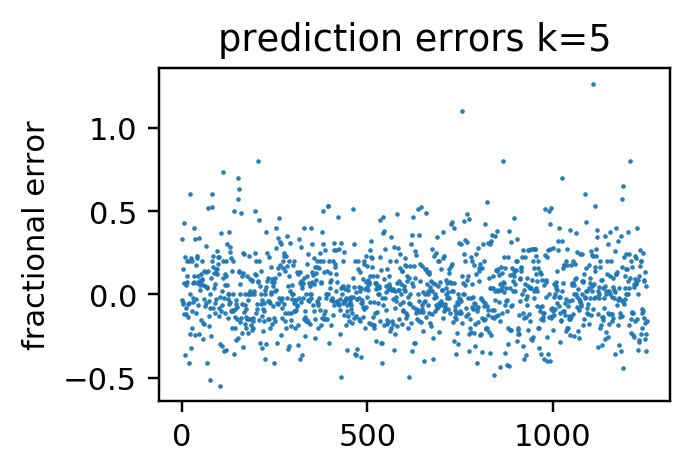

In [29]:
plt.figure(dpi=220, figsize=(3, 2))   # dots_per_inch and (width, height) in inches
plt.plot(fractional_errors, linestyle='none', marker='.', markersize=1)
plt.title(f'prediction errors k={k}')
plt.ylabel('fractional error')
plt.show()

Is this a good result? Hmmm.

TO DO : repeat with different features and/or different k.


# &nbsp;


# tests

In [ ]:
# testing get_column
column_one = normalize(get_column(abalone, 1))
standard_deviation(column_one), mean(column_one)

In [ ]:
# testing in-place normalize_column
t = [[1,2,3], 
     [4,5,6], 
     [10,11,12]]
normalize_column(t, 1) # in place
t

In [ ]:
# see if scratch's distance() function works and looks OK
row_a = raw_abalone[13][1:-1]  # random row; skip sex and target 
row_b = raw_abalone[17][1:-1]  # random row; skip sex and target 
print('row_a : ', row_a)
print('row_b : ', row_b)
print('distance between is ', distance(row_a, row_b))

In [ ]:
# looking at the data ...
# Is a a weight of 0.0 might a valid value? Maybe for tiny infants?? Hmmm.
for col in feature_columns:
    column = get_column(raw_abalone, col)
    print(f'column {col} has min={min(column):6.2f}, max={max(column):6.2f}')

In [ ]:
# make sure we know how to use the shuffle function
from random import shuffle
a = [1,2,3,4]
shuffle(a)
a